#   Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
!pip install smdebug

## Dataset
  Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
import sagemaker
import boto3

# Retrieve the sagemaker session
sagemaker_session=sagemaker.Session()

# Retrieve the sagemaker S3 bucket, region and role
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))



Default Bucket: sagemaker-ap-southeast-2-263436898058
AWS Region: ap-southeast-2
RoleArn: arn:aws:iam::263436898058:role/service-role/AmazonSageMaker-ExecutionRole-20191212T175637


In [5]:
inputs = f's3://{bucket}/dog'
inputs

's3://sagemaker-ap-southeast-2-263436898058/dog'

In [6]:
train_images_path = f"s3://{bucket}/dog/train"
print(train_images_path)
val_images_path = f"s3://{bucket}/dog/valid"
print(val_images_path)
test_images_path = f"s3://{bucket}/dog/test"
print(test_images_path)

s3://sagemaker-ap-southeast-2-263436898058/dog/train
s3://sagemaker-ap-southeast-2-263436898058/dog/valid
s3://sagemaker-ap-southeast-2-263436898058/dog/test


## Hyperparameter Tuning
** ** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [12]:
#  Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256]),
    "lr": sagemaker.tuner.ContinuousParameter(0.01, 0.1),
    "epochs": sagemaker.tuner.IntegerParameter(2, 20)
}

objective_metric_name = "average test accuracy"
objective_type = "Maximize"

metric_definitions = [{"Name": "average test accuracy", "Regex": "Test set: Average accuracy: ([0-9\\.]+)"}]

In [30]:
from sagemaker.pytorch import PyTorch

#  Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=2,
    instance_type="ml.m5.4xlarge",
) #  Your estimator here

tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [31]:
# 8:44 - 8：50
tuner.fit({"train": inputs}, wait=True)

..........................................................................!


In [32]:
#   Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-04-29 20:49:43 Starting - Preparing the instances for training
2022-04-29 20:49:43 Downloading - Downloading input data
2022-04-29 20:49:43 Training - Training image download completed. Training in progress.
2022-04-29 20:49:43 Uploading - Uploading generated training model
2022-04-29 20:49:43 Completed - Training job completed


{'_tuning_objective_metric': '"average test accuracy"',
 'batch-size': '"256"',
 'epochs': '14',
 'lr': '0.054015055533941515',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-04-29-20-44-21-873"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"ap-southeast-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-2-263436898058/pytorch-training-2022-04-29-20-44-21-873/source/sourcedir.tar.gz"'}

In [15]:
best_hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), 
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']
                  }
best_hyperparameters

In [14]:
best_hyperparameters = {'batch-size': 256,
 'epochs': '14',
 'lr': '0.054015055533941515'
                  }
best_hyperparameters

{'batch-size': 256, 'epochs': '14', 'lr': '0.054015055533941515'}

## Model Profiling and Debugging
  Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [16]:
#   Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1"
    }
)

[2022-04-30 22:12:45.952 ip-172-16-33-42:24544 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [17]:
#   Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name='dogImageEstimator',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=8,
    instance_type="ml.m5.4xlarge",
    hyperparameters=best_hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)#   Your estimator here

estimator.fit({"train": train_images_path, "valid": val_images_path, "test": test_images_path}, wait=True)

2022-04-30 22:12:55 Starting - Starting the training job...
2022-04-30 22:13:21 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-04-30 22:14:46 Downloading - Downloading input data......
2022-04-30 22:15:55 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-30 22:15:57,216 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-30 22:15:57,219 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-04-30 22:15:57,227 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-30 22:15:57,234 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-30 22:15:57,543 sagemaker-training-toolkit INFO  

[2022-04-30 22:16:03.893 algo-7:26 INFO hook.py:425] Monitoring the collections: gradients, losses
[2022-04-30 22:16:03.895 algo-7:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-7/prestepzero-*-start-1651356959189756.8_train-0-stepstart-1651356963894832.2/python_stats.
[2022-04-30 22:16:03.917 algo-7:26 INFO hook.py:488] Hook is writing from the hook with pid: 26
[2022-04-30 22:16:04.642 algo-3:26 INFO hook.py:425] Monitoring the collections: losses, gradients
[2022-04-30 22:16:04.644 algo-3:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-3/prestepzero-*-start-1651356959353825.8_train-0-stepstart-1651356964643781.8/python_stats.
[2022-04-30 22:16:04.663 algo-3:26 INFO hook.py:488] Hook is writing from the hook with pid: 26
[2022-04-30 22:16:04.355 algo-6:26 INFO hook.py:425] Monitoring the collections: losses, gradients
[2022-04-30 22:16:04.356 algo

[2022-04-30 22:16:22.336 algo-5:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-5/train-1-forwardpassend-1651356979370026.8_train-2-stepstart-1651356982336343.8/python_stats.
[2022-04-30 22:16:22.874 algo-8:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-8/train-1-forwardpassend-1651356978954936.8_train-2-stepstart-1651356982873863.0/python_stats.
[2022-04-30 22:16:26.215 algo-6:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-6/train-2-stepstart-1651356979789940.5_train-2-forwardpassend-1651356986215346.2/python_stats.
[2022-04-30 22:16:26.530 algo-7:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-7/train-2-stepstart-1651356980523710.8_train-2-forwardpassend-1651356986530132.8/python_stats.
[2022-04-30 22:16:26.347

[2022-04-30 22:16:46.419 algo-7:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-7/train-4-stepstart-1651356999576642.2_train-4-forwardpassend-1651357006419039.0/python_stats.
[2022-04-30 22:16:46.455 algo-2:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-2/train-4-stepstart-1651357000211258.5_train-4-forwardpassend-1651357006454723.5/python_stats.
[2022-04-30 22:16:46.807 algo-4:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-4/train-4-stepstart-1651357000091421.5_train-4-forwardpassend-1651357006806743.5/python_stats.
[2022-04-30 22:16:47.785 algo-5:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-5/train-4-stepstart-1651357001706197.5_train-4-forwardpassend-1651357007784614.0/python_stats.
[2022-04-30 22:16:48.156

[2022-04-30 22:17:09.063 algo-1:27 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/27-algo-1/train-6-forwardpassend-1651357025825826.0_train-7-stepstart-1651357029063353.8/python_stats.
[2022-04-30 22:17:09.266 algo-4:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-4/train-6-forwardpassend-1651357026620911.8_train-7-stepstart-1651357029265991.0/python_stats.
[2022-04-30 22:17:10.891 algo-5:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-5/train-6-forwardpassend-1651357027328506.0_train-7-stepstart-1651357030891014.5/python_stats.
[2022-04-30 22:17:08.071 algo-8:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-8/train-6-stepstart-1651357021524072.0_train-6-forwardpassend-1651357028070939.0/python_stats.
[2022-04-30 22:17:07.977

[2022-04-30 22:17:28.355 algo-2:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-2/train-8-forwardpassend-1651357044710753.2_train-9-stepstart-1651357048355162.8/python_stats.
[2022-04-30 22:17:28.328 algo-5:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-5/train-8-stepstart-1651357041442761.2_train-8-forwardpassend-1651357048328094.0/python_stats.
[2022-04-30 22:17:30.347 algo-8:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-8/train-8-forwardpassend-1651357046865559.8_train-9-stepstart-1651357050347502.2/python_stats.
[2022-04-30 22:17:31.259 algo-5:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-5/train-8-forwardpassend-1651357048329686.2_train-9-stepstart-1651357051258659.5/python_stats.
[2022-04-30 22:17:32.798

Test - Loss: 2.69, Accuracy: 68.0%
Epoch: 4
Test - Loss: 2.66, Accuracy: 69.0%
Epoch: 4
Test - Loss: 2.6, Accuracy: 70.0%
Epoch: 4
Test - Loss: 2.27, Accuracy: 70.0%
Epoch: 4
Train - Loss:1.18, Accuracy:83.0%
Train - Loss:1.03, Accuracy:83.0%
Train - Loss:1.12, Accuracy:82.0%
Train - Loss:1.05, Accuracy:84.0%
Train - Loss:1.09, Accuracy:82.0%
Train - Loss:1.18, Accuracy:82.0%
Valid - Loss:2.65, Accuracy:71.0%
Train - Loss:1.21, Accuracy:83.0%
Valid - Loss:2.66, Accuracy:68.0%
Train - Loss:0.99, Accuracy:84.0%
Valid - Loss:2.26, Accuracy:72.0%
Valid - Loss:2.21, Accuracy:72.0%
Valid - Loss:2.37, Accuracy:71.0%
Valid - Loss:2.44, Accuracy:72.0%
Test - Loss: 2.56, Accuracy: 70.0%
Epoch: 5
Test - Loss: 2.66, Accuracy: 69.0%
Epoch: 5
Valid - Loss:2.55, Accuracy:69.0%
Valid - Loss:2.29, Accuracy:72.0%
Test - Loss: 2.21, Accuracy: 73.0%
Epoch: 5
Test - Loss: 2.43, Accuracy: 72.0%
Epoch: 5
Test - Loss: 2.39, Accuracy: 71.0%
Epoch: 5
Test - Loss: 2.54, Accuracy: 71.0%
Epoch: 5
Test - Loss: 2.33

Test - Loss: 2.58, Accuracy: 75.0%
Epoch: 11
Train - Loss:0.94, Accuracy:89.0%
Valid - Loss:2.51, Accuracy:74.0%
Test - Loss: 2.82, Accuracy: 74.0%
Epoch: 11
Valid - Loss:3.1, Accuracy:72.0%
Test - Loss: 2.92, Accuracy: 72.0%
Epoch: 11
Test - Loss: 3.44, Accuracy: 71.0%
Epoch: 11
Train - Loss:0.69, Accuracy:90.0%
Train - Loss:0.76, Accuracy:89.0%
Train - Loss:0.93, Accuracy:88.0%
Train - Loss:0.61, Accuracy:90.0%
Train - Loss:0.44, Accuracy:93.0%
Valid - Loss:3.25, Accuracy:71.0%
Valid - Loss:3.2, Accuracy:71.0%
Train - Loss:0.61, Accuracy:90.0%
Valid - Loss:2.88, Accuracy:74.0%
Valid - Loss:3.2, Accuracy:71.0%
Valid - Loss:2.76, Accuracy:72.0%
Test - Loss: 3.45, Accuracy: 70.0%
Epoch: 12
Train - Loss:0.57, Accuracy:92.0%
Test - Loss: 3.17, Accuracy: 70.0%
Epoch: 12
Valid - Loss:3.37, Accuracy:70.0%
Test - Loss: 3.2, Accuracy: 73.0%
Epoch: 12
Test - Loss: 3.44, Accuracy: 69.0%
Epoch: 12
Test - Loss: 2.64, Accuracy: 73.0%
Epoch: 12
Train - Loss:0.95, Accuracy:90.0%
Valid - Loss:2.71, Ac

Train - Loss:0.53, Accuracy:92.0%
Valid - Loss:3.3, Accuracy:71.0%
Valid - Loss:3.25, Accuracy:73.0%
Test - Loss: 3.13, Accuracy: 74.0%
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
#015  0%|          | 0.00/44.7M [00:00<?, ?B/s]#015 11%|█         | 5.02M/44.7M [00:00<00:00, 52.5MB/s]#015 23%|██▎       | 10.1M/44.7M [00:00<00:00, 52.9MB/s]#015 38%|███▊      | 17.2M/44.7M [00:00<00:00, 62.6MB/s]#015 57%|█████▋    | 25.6M/44.7M [00:00<00:00, 72.8MB/s]#015 76%|███████▌  | 34.0M/44.7M [00:00<00:00, 78.4MB/s]#015 95%|█████████▌| 42.5M/44.7M [00:00<00:00, 82.0MB/s]#015100%|██████████| 44.7M/44.7M [00:00<00:00, 74.6MB/s]
2022-04-30 23:04:35,184 sagemaker-training-toolkit INFO     Reporting training SUCCESS
Test - Loss: 3.32, Accuracy: 72.0%
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
#015  0%|          | 0.00/44.7M [00:

In [ ]:
#   Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name='dogImageEstimator',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p2.xlarge",
    hyperparameters=best_hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)#   Your estimator here

estimator.fit({"train": train_images_path, "valid": val_images_path, "test": test_images_path}, wait=True)

2022-04-29 21:28:46 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-04-29 21:29:33 Starting - Preparing the instances for training.........
2022-04-29 21:31:14 Downloading - Downloading input data.........
2022-04-29 21:32:35 Training - Downloading the training image..........................
2022-04-29 21:37:16 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-29 21:37:03,899 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-29 21:37:03,930 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-29 21:37:03,941 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-29 21:37:05,015 sagemaker-training-toolkit INFO     Invoking us

[2022-04-29 21:37:37.670 algo-1:28 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/28-algo-1/train-0-stepstart-1651268237670972.2_train-0-forwardpassend-1651268257669766.2/python_stats.
[2022-04-29 21:37:41.578 algo-1:28 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/28-algo-1/train-0-forwardpassend-1651268257673192.8_train-1-stepstart-1651268261576317.5/python_stats.
[2022-04-29 21:38:11.539 algo-1:28 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/28-algo-1/train-1-stepstart-1651268261584133.0_train-1-forwardpassend-1651268291539085.8/python_stats.
[2022-04-29 21:38:15.967 algo-1:28 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/28-algo-1/train-1-forwardpassend-1651268291542476.0_train-2-stepstart-1651268295964179.8/python_stats.
[2022-04-29 21:38:46.612

In [17]:
#   Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name='dogImageEstimator',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=4,
    instance_type="ml.m5.4xlarge",
    hyperparameters=best_hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)#   Your estimator here

estimator.fit({"train": train_images_path, "valid": val_images_path, "test": test_images_path}, wait=True)

2022-04-29 11:42:37 Starting - Starting the training job...
2022-04-29 11:43:02 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-04-29 11:44:28 Downloading - Downloading input data.........
2022-04-29 11:46:01 Training - Downloading the training image..........................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-29 11:50:24,340 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-29 11:50:24,375 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-29 11:50:24,384 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-29 11:50:25,021 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dir

[2022-04-29 11:51:05.325 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-1-stepstart-1651233046781431.2_train-1-forwardpassend-1651233065324386.8/python_stats.
256/6680 images trained...
[2022-04-29 11:51:07.557 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-1-forwardpassend-1651233065328402.5_train-2-stepstart-1651233067556480.0/python_stats.
[2022-04-29 11:51:24.784 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-2-stepstart-1651233067561734.0_train-2-forwardpassend-1651233084783813.2/python_stats.
384/6680 images trained...
[2022-04-29 11:51:27.065 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-2-forwardpassend-1651233084786295.8_train-3-stepstart-165

5760/6680 images trained...
5888/6680 images trained...
6016/6680 images trained...
6144/6680 images trained...
6272/6680 images trained...
6400/6680 images trained...
6528/6680 images trained...
6656/6680 images trained...
6680/6680 images trained...

2022-04-29 12:15:39 Uploading - Uploading generated training modelAccuracy: 72.81437125748504%, Testing Loss: 1.1113403233225474
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
#015  0%|          | 0.00/44.7M [00:00<?, ?B/s]#015 10%|▉         | 4.40M/44.7M [00:00<00:00, 46.1MB/s]#015 20%|█▉        | 8.80M/44.7M [00:00<00:00, 45.1MB/s]#015 32%|███▏      | 14.4M/44.7M [00:00<00:00, 51.3MB/s]#015 45%|████▌     | 20.1M/44.7M [00:00<00:00, 54.8MB/s]#015 57%|█████▋    | 25.4M/44.7M [00:00<00:00, 55.0MB/s]#015 70%|██████▉   | 31.1M/44.7M [00:00<00:00, 56.3MB/s]#015 82%|████████▏ | 36.7M/44.7M [00:00<00:00, 57.2MB/s]#015 94%|█████████▍| 42.1M/44.7M [00:00<00:00,

In [18]:
#   Plot a debugging output.
import smdebug

job_name = estimator.latest_training_job.name
print(job_name)
client = estimator.sagemaker_session.sagemaker_client
print(client)
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(description)
trial = smdebug.trials.create_trial(estimator.latest_job_debugger_artifacts_path())
print(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

dogImageEstimator-2022-04-30-22-12-55-104
{'TrainingJobName': 'dogImageEstimator-2022-04-30-22-12-55-104', 'TrainingJobArn': 'arn:aws:sagemaker:ap-southeast-2:263436898058:training-job/dogimageestimator-2022-04-30-22-12-55-104', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '256', 'epochs': '"14"', 'lr': '"0.054015055533941515"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"dogImageEstimator-2022-04-30-22-12-55-104"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"ap-southeast-2"', 'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/pytorch-training:1.8-cpu-py36', 'Trai

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-04-30 23:06:13.573 ip-172-16-33-42:24544 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 231 more expected)', IncompleteRead(0 bytes read, 231 more expected)) while reading s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/debug-output/index/000000000/000000000132_worker_0.json . Will retry now
s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/debug-output
[2022-04-30 23:06:15.184 ip-172-16-33-42:24544 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-04-30 23:06:16.206 ip-172-16-33-42:24544 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [8]:
deploy_estimator = sagemaker.estimator.Estimator.attach("dogImageEstimator-2022-04-30-11-29-05-406")


2022-04-30 12:21:12 Starting - Preparing the instances for training
2022-04-30 12:21:12 Downloading - Downloading input data
2022-04-30 12:21:12 Training - Training image download completed. Training in progress.
2022-04-30 12:21:12 Uploading - Uploading generated training model
2022-04-30 12:21:12 Completed - Training job completed


In [10]:
estimator = deploy_estimator

In [19]:
#   Plot a debugging output.
import smdebug

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
trial = smdebug.trials.create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-04-30 23:06:16.242 ip-172-16-33-42:24544 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/debug-output
[2022-04-30 23:06:16.450 ip-172-16-33-42:24544 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 392 more expected)', IncompleteRead(0 bytes read, 392 more expected)) while reading s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2022-04-30 23:06:17.674 ip-172-16-33-42:24544 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-04-30 23:06:18.696 ip-172-16-33-42:24544 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [20]:
from smdebug.core.modes import ModeKeys

len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

38

In [21]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

112

In [22]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


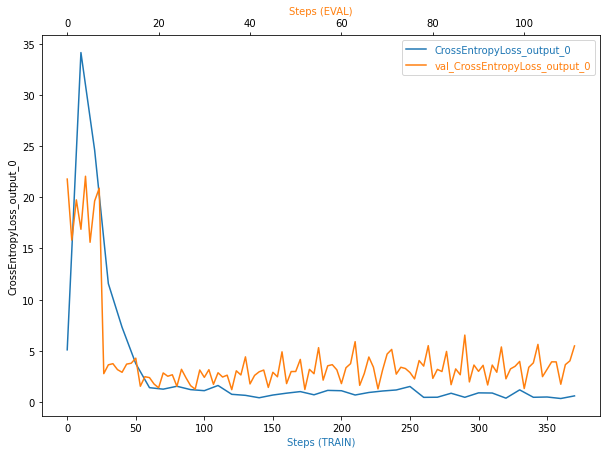

In [24]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [25]:
#   Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/rule-output'

In [26]:
!aws s3 ls {rule_output_path} --recursive

2022-04-30 23:05:16     418386 dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-04-30 23:05:15     267079 dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-04-30 23:05:11        192 dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-04-30 23:05:11        201 dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-04-30 23:05:11       1953 dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-04-30 23:05:11        127 dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-04-30 23:05:11        200 dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/prof

In [27]:
!aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-ap-southeast-2-263436898058/dogImageEstimator-2022-04-30-22-12-55-104/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemak

In [28]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [29]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [30]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=estimator.model_data, 
                             role=role, 
                             entry_point='inference.py', 
                             py_version='py36',
                             framework_version='1.8')


predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-----!

In [32]:
!pip3 install torch torchvision --no-cache-dir

     |████████████████████████████████| 881.9 MB 67.7 MB/s            
     |████████████████████████████████| 23.3 MB 27.1 MB/s            
     |████████████████████████████████| 881.9 MB 66.3 MB/s            


In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import Image as ImageDisplay
import io

In [34]:
from sagemaker.serializers import IdentitySerializer
predictor.serializer = IdentitySerializer("image/jpeg")

In [35]:


def inference(image_path):    
    buf = io.BytesIO()
    Image.open(image_path).save(buf, format="JPEG")
    response = predictor.predict(buf.getvalue())
    
    return response

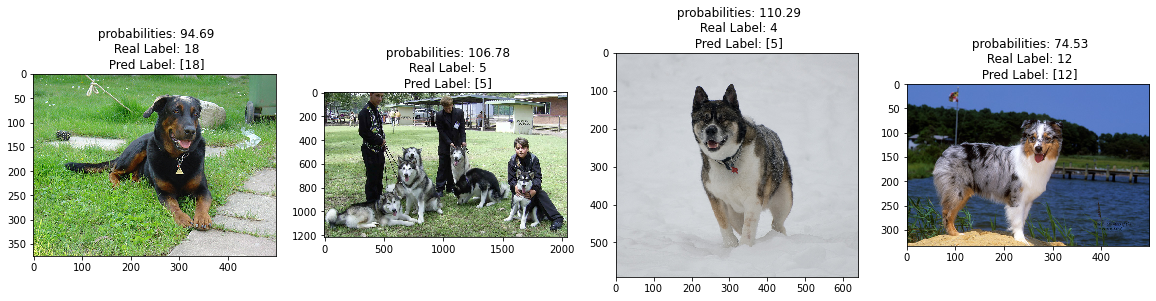

In [36]:
image_arr = ["./dogImages/test/018.Beauceron/Beauceron_01284.jpg", 
               "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00387.jpg", 
               "./dogImages/test/004.Akita/Akita_00244.jpg", 
               "./dogImages/test/012.Australian_shepherd/Australian_shepherd_00887.jpg"]


columns = len(image_arr)
rows = 1
fig = plt.figure(figsize=(20,20))
for i, image_path in enumerate(image_arr):
    # sub img position
    fig.add_subplot(rows, columns, i+1)
    
    image = Image.open(image_path)
    
    response = inference(image_path)
    pred = np.argmax(response, 1) + 1
        
    plt.imshow(image, interpolation='nearest')
    plt.title(f" probabilities: {round(np.max(response),2)}\n Real Label: {int(image_path[17:20])}\n Pred Label: {pred}")
#plt.savefig(path.join(figures_dir, "visualization_predicted_images.pdf"), bbox_inches = 'tight')
plt.show()

In [38]:
#   Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()